In [35]:
import os
import json
import cv2
import numpy as np
import time
# root = '/checkpoint/apratik/finals/default/apartment_0/'

# def make_data(root, img_indx):
#     src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
#     src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
#     src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
#     with open(os.path.join(root, "data.json"), "r") as f:
#         base_pose_data = json.load(f)
#     src_pose = base_pose_data["{}".format(img_indx)]
#     cur_pose = base_pose_data["{}".format(img_indx+5)]
#     cur_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx+5)))
#     cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
#     print(f'{type(src_img), type(src_depth), type(src_label)}')
#     # Visualize label
#     return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label
    
# src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cur_label = make_data(root, 1)

# hello_root = '/checkpoint/apratik/robot_trajectories/active/1/'
# def get_hello_data(root, img_indx):
#     src_img = cv2.imread(os.path.join(hello_root, f"rgb/{img_indx}.jpg"))
#     src_depth = np.load(os.path.join(hello_root, f"depth/{img_indx}.npy"))
#     src_label = np.load(os.path.join(hello_root, f"seg/{img_indx}.npy"))
#     with open(os.path.join(hello_root, "data.json"), "r") as f:
#         base_pose_data = json.load(f)
#     src_pose = base_pose_data["{}".format(img_indx)]['base_xyt']
#     cam_transform = np.asarray(base_pose_data["{}".format(img_indx)]['cam_transform'])
    
#     cur_pose = base_pose_data["{}".format(img_indx+5)]['base_xyt']
#     cur_depth = np.load(os.path.join(hello_root, f"depth/{img_indx+5}.npy"))
#     # cur_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx+5)))
#     print(f'{type(src_img), type(src_depth), type(src_label)}')
#     # Visualize label
#     return src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform
    
# src_img, src_depth, src_label, src_pose, cur_pose, cur_depth, cam_transform = get_hello_data(root, 100)


from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

from utils import d3_40_colors_rgb

def display_sample(src_img, semantic1, semantic2, depth_obs):
    
    arr = [src_img]
    for semantic_obs in [semantic1, semantic2]:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
    
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
    arr.append(depth_img)
    
    titles = ['src_img', 'src', 'propagated', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 4, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

from droidlet.lowlevel.robot_mover_utils import transform_pose
from copy import deepcopy as copy
from numba import njit
import random
from math import floor, ceil

"""
1. Find pixel index for each label, keep the pts list pts_in_world
2. for each set, transform pts_in_world to current image frame
3. Do filteration - if norm(original pixel - current pixel) is greater than threshold, set it to false
4. Do quantization fix 

"""

import open3d as o3d

def compute_uvone_hello(height, width, cam_transform):
    # 640 / 480, so ppx and ppy are the center of the camera
    # realsense DEPTH_UNITS is 0.001, i.e. it's depth units are in mm
    fx, fy = 605.2880249, 605.65637207
    cx, cy = 319.11114502, 239.48382568
    intrinsic_mat = np.array([[  fx, 0., cx],
                              [  0., fy, cy],
                              [  0., 0., 1.]])
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_pixs = np.mgrid[0 : height : 1, 0 : width : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    extrinsic = cam_transform
    rot_cam = extrinsic[:3, :3]
    trans_cam = extrinsic[:3, 3]
    
    return uv_one_in_cam, intrinsic_mat, rot_cam, trans_cam

def compute_uvone(height, width):
    intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
    rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
    trans = np.array([0, 0, 0.6])
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

@njit
def get_annot(height, width, pts_in_cur_img, src_label):
    annot_img = np.zeros((height, width))
    
    def get_row_col(x, h, w):
        # x = r*w + c
        r = int(x/w)
        c = int(x - r*w)
        return r, c
    
    for x in range(len(pts_in_cur_img)):
        r, c = get_row_col(x, height, width)
        x, y, _ = pts_in_cur_img[x]
        
        # Take ceil and floor combination to fix quantization errors
        if floor(x) >= 0 and ceil(x) < height and floor(y) >=0 and ceil(y) < width:
            annot_img[ceil(y)][ceil(x)] = src_label[r][c]
            annot_img[floor(y)][floor(x)] = src_label[r][c]
            annot_img[ceil(y)][floor(x)] = src_label[r][c]
            annot_img[floor(y)][ceil(x)] = src_label[r][c]
    
    return annot_img



def label_prop(
    src_img,
    src_depth,
    src_label,
    src_pose,
    base_pose,
    cur_depth,
):
    
    height, width, _ = src_img.shape
    uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
    
    pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
    cur_pts_in_world = convert_depth_to_pcd(cur_depth, base_pose, uv_one_in_cam, rot, trans)
    
    # convert pts_in_world to current base
    pts_in_cur_base = transform_pose(pts_in_world, (-base_pose[0], -base_pose[1], 0))
    pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

    # conver point from current base to current camera frame
    pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
    pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

    # conver pts in current camera frame into 2D pix values
    pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
    pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])
    
    return get_annot(height, width, pts_in_cur_img, src_label)


def lp_old(    
        src_img,
        src_depth,
        src_label,
        src_pose,
        base_pose,
        cur_depth,
    ):
        """Gets point cloud -> Transpose the point cloud based on robot location -> Project the point cloud back the images
        Args:
            src_img (np.ndarray): source image to propagte from
            src_depth (np.ndarray): source depth to propagte from
            src_label (np.ndarray): source semantic map to propagte from
            src_pose (np.ndarray): (x,y,theta) of the source image
            base_pose (np.ndarray): (x,y,theta) of current image
            cur_depth (np.ndarray): current depth
        """

        ### data needed to convert depth img to pointcloud ###
        # values extracted from pyrobot habitat agent
        intrinsic_mat = np.array([[256, 0, 256], [0, 256, 256], [0, 0, 1]])
        rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
        trans = np.array([0, 0, 0.6])
        # precompute some values necessary to depth to point cloud
        intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
        height, width, channels = src_img.shape
        img_resolution = (height, width)
        img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
        img_pixs = img_pixs.reshape(2, -1)
        img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
        uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
        uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)

        ### calculate point cloud in different frmaes ###
        # point cloud in camera frmae
        depth = (src_depth.astype(np.float32) / 1000.0).reshape(-1)
        pts_in_cam = np.multiply(uv_one_in_cam, depth)
        pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
        # point cloud in robot base frame
        pts_in_base = pts_in_cam[:3, :].T
        pts_in_base = np.dot(pts_in_base, rot.T)
        pts_in_base = pts_in_base + trans.reshape(-1)
        # point cloud in world frame (pyrobot)
        pts_in_world = transform_pose(pts_in_base, src_pose)

        ### figure out unique label values in provided gt label which is greater than 0 ###
        unique_pix_value = np.unique(src_label.reshape(-1), axis=0)
        unique_pix_value = [i for i in unique_pix_value if np.linalg.norm(i) > 0]

        ### for each unique label, figure out points in world frame ###
        # first figure out pixel index
        indx = [zip(*np.where(src_label == i)) for i in unique_pix_value]
        # convert pix index to index in point cloud
        # refer this https://www.codepile.net/pile/bZqJbyNz
        indx = [[i[0] * width + i[1] for i in j] for j in indx]
        # take out points in world space correspoinding to each unique label
        req_pts_in_world_list = [pts_in_world[indx[i]] for i in range(len(indx))]

        # param useful to search nearest point cloud in a region
        kernal_size = 3

        # convert depth to point cloud in camera frame
        cur_depth = (cur_depth.astype(np.float32) / 1000.0).reshape(-1)
        cur_pts_in_cam = np.multiply(uv_one_in_cam, cur_depth)
        cur_pts_in_cam = np.concatenate(
            (cur_pts_in_cam, np.ones((1, cur_pts_in_cam.shape[1]))), axis=0
        )
        # convert point cloud in camera frame to base frame
        cur_pts_in_base = cur_pts_in_cam[:3, :].T
        cur_pts_in_base = np.dot(cur_pts_in_base, rot.T)
        cur_pts_in_base = cur_pts_in_base + trans.reshape(-1)
        # convert point cloud from base frame to world frame
        cur_pts_in_world = transform_pose(cur_pts_in_base, base_pose)

        ### generate label for new img ###
        # crete annotation files with all zeros
        annot_img = np.zeros((height, width))
        # do label prpogation for each unique label in provided gt seg label
        for i, (req_pts_in_world, pix_color) in enumerate(
            zip(req_pts_in_world_list, unique_pix_value)
        ):
            # convert point cloud for label from world pose to current (img_indx) base pose
            pts_in_cur_base = copy(req_pts_in_world)
            pts_in_cur_base = transform_pose(pts_in_cur_base, (-base_pose[0], -base_pose[1], 0))
            pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -base_pose[2]))

            # conver point from current base to current camera frame
            pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
            pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

            # conver pts in current camera frame into 2D pix values
            pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
            pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])

            # filter out index which fall beyond the shape of img size
            filtered_img_indx = np.logical_and(
                np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
                np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
            )

            # only consider depth matching for these points
            # filter out point based on projected depth value wold frame, this helps us get rid of pixels for which view to the object is blocked by any other object, as in that was projected 3D point in wolrd frmae for the current pix won't match with 3D point in the gt provide label
            dist_thr = 5e-2  # this is in meter
            for pixel_index in range(len(filtered_img_indx)):
                if filtered_img_indx[pixel_index]:
                    # search in the region
                    gt_pix_depth_in_world = req_pts_in_world[pixel_index]
                    p, q = np.meshgrid(
                        range(
                            int(pts_in_cur_img[pixel_index][1] - kernal_size),
                            int(pts_in_cur_img[pixel_index][1] + kernal_size),
                        ),
                        range(
                            int(pts_in_cur_img[pixel_index][0] - kernal_size),
                            int(pts_in_cur_img[pixel_index][0] + kernal_size),
                        ),
                    )
                    loc = p * width + q
                    loc = loc.reshape(-1).astype(np.int32)
                    loc = np.clip(loc, 0, width * height - 1).astype(np.int32)

                    if (
                        min(np.linalg.norm(cur_pts_in_world[loc] - gt_pix_depth_in_world, axis=1))
                        > dist_thr
                    ):
                        filtered_img_indx[pixel_index] = False

            # take out filtered pix values
            pts_in_cur_img = pts_in_cur_img[filtered_img_indx]

            # step to take care of quantization errors
            pts_in_cur_img = np.concatenate(
                (
                    np.concatenate(
                        (
                            np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.ceil(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.floor(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                    np.concatenate(
                        (
                            np.floor(pts_in_cur_img[:, 0]).reshape(-1, 1),
                            np.ceil(pts_in_cur_img[:, 1]).reshape(-1, 1),
                        ),
                        axis=1,
                    ),
                )
            )
            pts_in_cur_img = pts_in_cur_img[:, :2].astype(int)

            # filter out index which fall beyond the shape of img size, had to perform this step again to take care if any out of the image size point is introduced by the above quantization step
            pts_in_cur_img = pts_in_cur_img[
                np.logical_and(
                    np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
                    np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
                )
            ]

            # number of points for the label found in cur img
            # print("pts in cam = {}".format(len(pts_in_cur_cam)))

            # assign label to correspoinding pix values
            annot_img[pts_in_cur_img[:, 1], pts_in_cur_img[:, 0]] = pix_color

        return annot_img

In [74]:
# Test

test_assets = 'label_prop_test_assets'

def run_label_prop(traj_dir, gt_frame_id, prop_length, read_fn, save_folder):
    src_img, src_label, src_depth, src_pose, cam_transform = read_fn(traj_dir, gt_frame_id)
    height, width, _ = src_img.shape
    propagated = []
    
    for x in range(gt_frame_id-prop_length, gt_frame_id+prop_length+1):
        cur_img, _, cur_depth, cur_pose, cam_transform = read_fn(traj_dir, x)
        cur_label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
        # cur_label = lp_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

        propagated.append((x, cur_img, cur_label))

def read_test_asset_idx(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb_{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth_{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg_{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    
    # Visualize label
    return src_img, src_label, src_depth, src_pose, None
 
def calculate_accuracy(act, pred):
    h, w = act.shape
    assert act.shape == pred.shape
    
    correct = np.sum(act[pred != 0] == pred[pred != 0])
    total = np.sum(pred != 0)
    
    return correct/total
            
    
def test_label_prop_nonoise():
    # load src
    data_dir = os.path.join(test_assets, 'no_noise')
    _run_test(data_dir)
#     start = time.time()
#     prop_label = lp_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
#     end = time.time()
#     print(f'old time {end-start}')
    
#     display_sample(src_img, cur_label, prop_label, src_depth)
#     # calculate metrics 
    
#     acc = calculate_accuracy(cur_label, prop_label)
#     print(f'accuracy {acc}')
    
def _run_test(data_dir):
    for x in os.listdir(data_dir):
        dd = os.path.join(data_dir, x)
        
        # get ids
        ids = []
        with open(os.path.join(dd, 'gtids.txt'), 'r') as f:
            ids = f.readlines()
            ids = [int(x.strip()) for x in ids]
            
        print(type(ids[0]))
            
            
        src_img, src_label, src_depth, src_pose, cam_transform = read_test_asset_idx(dd, ids[0])
        # load dst
        cur_img, cur_label, cur_depth, cur_pose, cam_transform = read_test_asset_idx(dd, ids[1])
        # call label prop 
        start = time.time()
        prop_label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
        end = time.time()
        print(f'new time {end-start}')

        display_sample(src_img, cur_label, prop_label, src_depth)
        # calculate metrics 

        acc = calculate_accuracy(cur_label, prop_label)
        assert acc*100 > 90, f'accuracy {acc} < 90'
        print(f'accuracy {acc}')
        
def test_label_prop_noise():
    # load src
    data_dir = os.path.join(test_assets, 'noise')
    _run_test(data_dir)
    
#     start = time.time()
#     prop_label = lp_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
#     end = time.time()
#     print(f'old time {end-start}')
    
#     display_sample(src_img, cur_label, prop_label, src_depth)
#     # calculate metrics 
    
#     acc = calculate_accuracy(cur_label, prop_label)
#     print(f'accuracy {acc}')

<class 'int'>
new time 0.04256272315979004


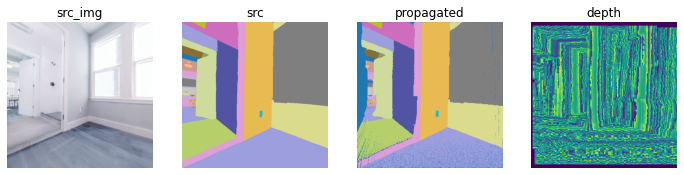

accuracy 0.9449529703978174
<class 'int'>
new time 0.04094409942626953


/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in true_divide


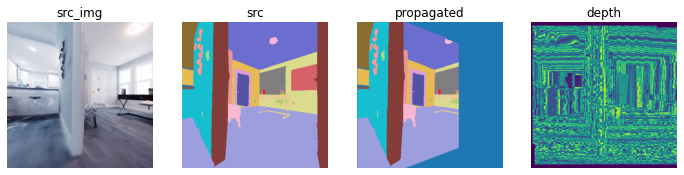

accuracy 0.9703793223973791
<class 'int'>
new time 0.03938150405883789


/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/ipykernel_launcher.py:184: RuntimeWarning: divide by zero encountered in true_divide


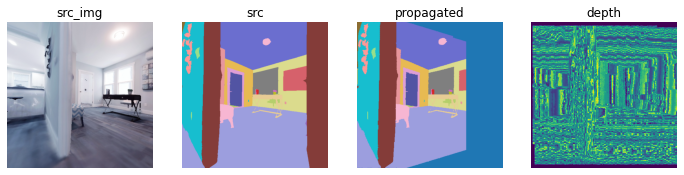

accuracy 0.9329298351317303
<class 'int'>
new time 0.03976869583129883


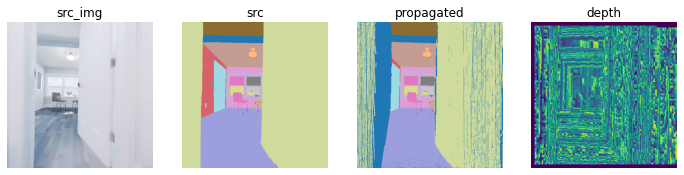

accuracy 0.9712004402718118
<class 'int'>
new time 0.03843855857849121


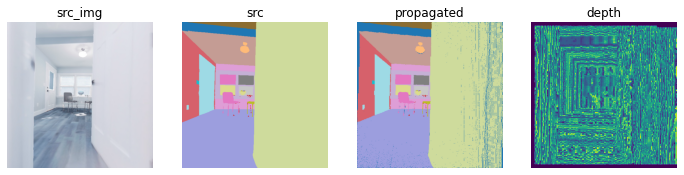

accuracy 0.9829177913718475
<class 'int'>
new time 0.041886091232299805


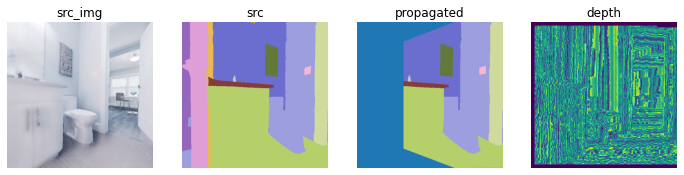

accuracy 0.9916168384363451
<class 'int'>
new time 0.040280818939208984


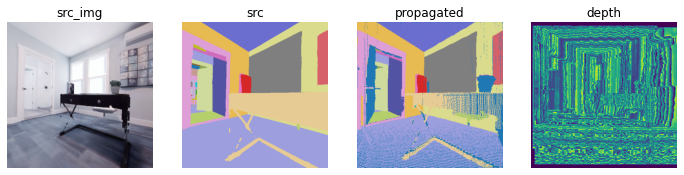

accuracy 0.9101094378365292
<class 'int'>
new time 0.04096579551696777


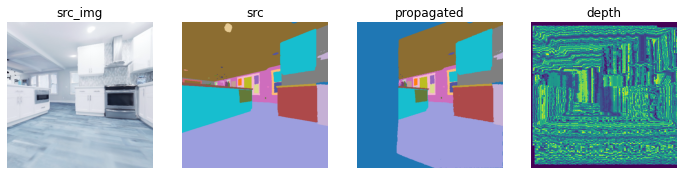

accuracy 0.9722134143288663
<class 'int'>
new time 0.04085230827331543


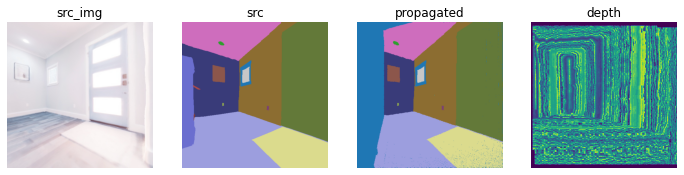

accuracy 0.9934039156373414
<class 'int'>
new time 0.07237887382507324


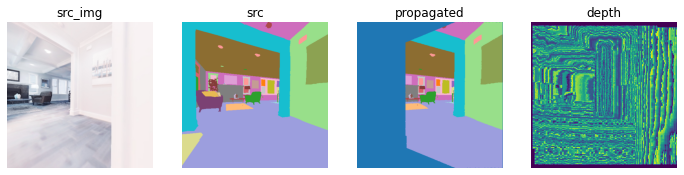

accuracy 0.9883697217261261
<class 'int'>
new time 0.04028820991516113


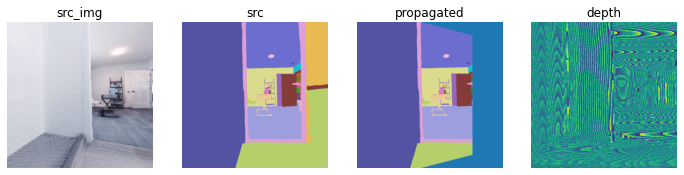

accuracy 0.9902413711452912
<class 'int'>
new time 0.03977656364440918


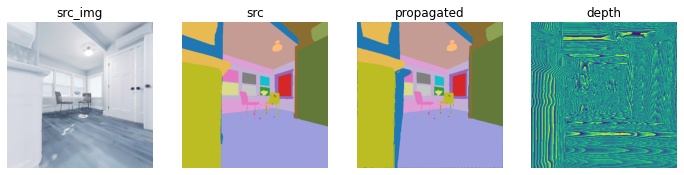

accuracy 0.9738032166128688
<class 'int'>
new time 0.040025949478149414


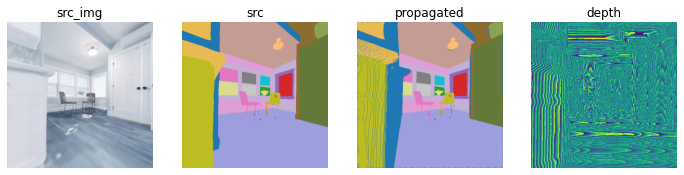

accuracy 0.9695975939747419
<class 'int'>
new time 0.0402374267578125


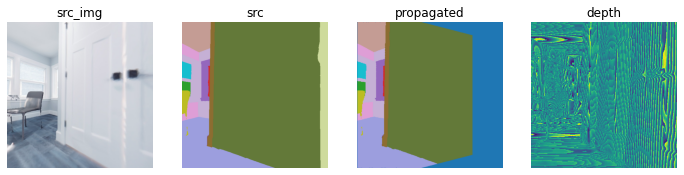

accuracy 0.993616839050637
<class 'int'>
new time 0.0400538444519043


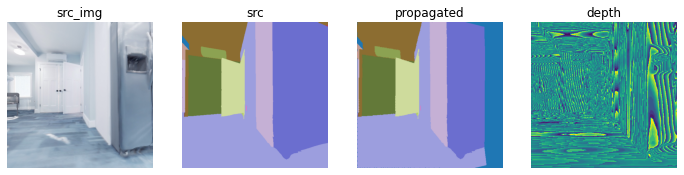

accuracy 0.9674940484525977
<class 'int'>
new time 0.05136251449584961


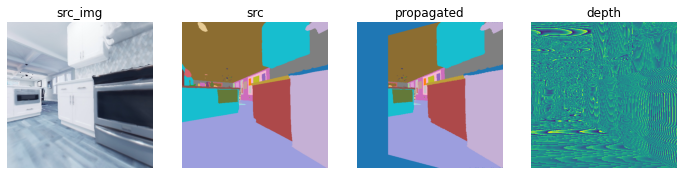

accuracy 0.9896534120489479
<class 'int'>
new time 0.03932070732116699


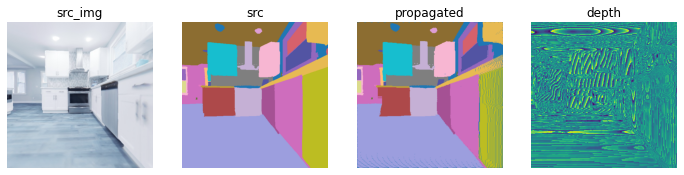

accuracy 0.9718721107572681
<class 'int'>
new time 0.042098283767700195


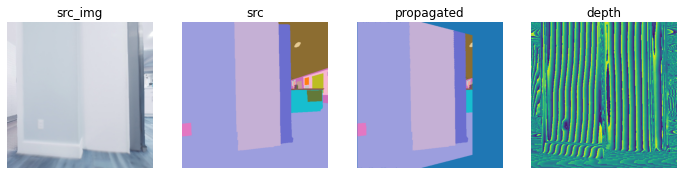

accuracy 0.9946899355638291
<class 'int'>
new time 0.0411372184753418


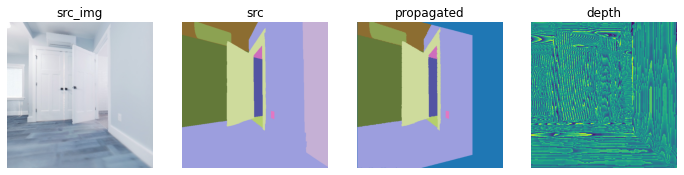

accuracy 0.9926092366908323
<class 'int'>
new time 0.04037022590637207


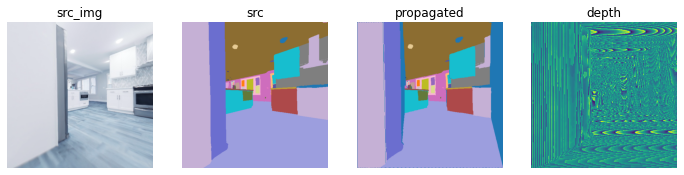

accuracy 0.9858020374286942


In [75]:
test_label_prop_noise()
test_label_prop_nonoise()

In [2]:
# import time

# nstart = time.time()
# label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

# nend = time.time()
# display_sample(src_img, src_label, label)

# ostart = time.time()
# label = label_prop_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
# oend = time.time()

# display_sample(src_img, src_label, label)

# print(f'new time {nend-nstart}')
# print(f'old time {oend-ostart}')

In [3]:
# write a fn that takes in a GT frame, prop length and propagates

def visualize(images, height, width, save_folder):
    color_dict = {}
    
    if os.path.isdir(save_folder):
        import shutil
        shutil.rmtree(save_folder)
        
    os.makedirs(save_folder)
    
    for filename, image, masks in images:
        image = image.astype(np.uint8)
        # print(np.unique(masks))

        for x in np.unique(masks):
            if x > 0:
                binary_mask = (masks == x).astype(np.uint8)
                # print(binary_mask.shape, np.unique(binary_mask))
                # print(image.shape, binary_mask.shape)
                
                if x not in color_dict.keys():
                    color = list(np.random.choice(range(256), size=3))
                    color_dict[x] = color
                    
                color = color_dict[x]
                image[binary_mask == 1] = image[binary_mask == 1] * 0.4 + np.asarray(color) * 0.6
                # image = cv2.bitwise_or(image, image, binary_mask)
        
        cv2.imwrite('{}/{:05d}.jpg'.format(save_folder, filename), image) 
        # plt.imshow(image)
        # plt.show()
        
import subprocess

def run_label_prop(traj_dir, gt_frame_id, prop_length, read_fn, save_folder):
    src_img, src_label, src_depth, src_pose, cam_transform = read_fn(traj_dir, gt_frame_id)
    height, width, _ = src_img.shape
    propagated = []
    
    for x in range(gt_frame_id-prop_length, gt_frame_id+prop_length+1):
        cur_img, _, cur_depth, cur_pose, cam_transform = read_fn(traj_dir, x)
        cur_label = label_prop(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)
        # cur_label = lp_old(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

        propagated.append((x, cur_img, cur_label))
        
    visualize(propagated, height, width, save_folder)
    subprocess.call(f'ffmpeg -framerate 10 -f image2 -start_number {gt_frame_id-prop_length} -i {save_folder}/%05d.jpg {save_folder}/out.gif', shell=True)

        

def read_habitat_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, "rgb/{:05d}.jpg".format(img_indx)))
    src_depth = np.load(os.path.join(root, "depth/{:05d}.npy".format(img_indx)))
    src_label = np.load(os.path.join(root, "seg/{:05d}.npy".format(img_indx)))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]
    
    # Visualize label
    return src_img, src_label, src_depth, src_pose, None
    
def read_hello_data(root, img_indx):
    src_img = cv2.imread(os.path.join(root, f"rgb/{img_indx}.jpg"))
    src_depth = np.load(os.path.join(root, f"depth/{img_indx}.npy"))
    src_label = None
    if os.path.isfile(os.path.join(root, f"seg/{img_indx}.npy")):
        src_label = np.load(os.path.join(root, f"seg/{img_indx}.npy"))
    with open(os.path.join(root, "data.json"), "r") as f:
        base_pose_data = json.load(f)
    src_pose = base_pose_data["{}".format(img_indx)]['base_xyt']
    cam_transform = np.asarray(base_pose_data["{}".format(img_indx)]['cam_transform'])
    return src_img, src_label, src_depth, src_pose, cam_transform

In [4]:
start = time.time()
run_label_prop('/checkpoint/apratik/finals/default/apartment_0/', 250, 10, read_habitat_data, 'hab1_new')
end = time.time()
print(f'new impl {end-start}')

new impl 3.7087666988372803


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/pkg-config
  lib

In [5]:
run_label_prop('/checkpoint/apratik/robot_trajectories/active/7/', 100, 50, read_hello_data, 'hello7a')

/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in true_divide
/private/home/apratik/miniconda3/envs/droidlet/lib/python3.7/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in true_divide
ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enabl